In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
%matplotlib inline

### Changes in the feature extraction/feature selection/processing

I have altered the `CountVectorizer` to discount stopwords and strip accents. I had tried it with `n_grams` as well but using the simple representation does not lead to a degradation in the preceived performance so I decided to use the simpler representation:

```python

count = CountVectorizer(stop_words='english', strip_accents='ascii')

```


In [3]:
import pandas as pd

class ProcessAmazon():
    """Read, filter, aggregate by ProductId, and generate X matrix"""

    def __init__(self, raw_data_filename, num_reviews_filter):
        """Initialize attributes."""
        self.raw_data_filename = raw_data_filename
        self.num_reviews_filter = num_reviews_filter
        self.raw_data = self.read_and_report()
        self.grouped_by_userid = self.group_by_userid()
        self.filtered = self.filter_()
        self.grouped_by_productid = self.group_by_productid()
        self.X = self.write_X()
    
    def read_and_report(self):
        """Read Amazon csv, report on file structure"""
        data = pd.read_csv(self.raw_data_filename)
        print(self.raw_data_filename, "has", data.shape[0], "rows and", data.shape[1], "columns. First five observations:")
        print(data.head(5))
        print(50 * '-')
        return data
    
    def group_by_userid(self):
        """Group by UserId and look at the distribution of number of reviews"""
        grouped_by_uid = self.raw_data.groupby('UserId').count()
        print('Distribution of number of reviews for each UserId:')
        print(grouped_by_uid['ProductId'].value_counts())
        print(50 * '-')
        return grouped_by_uid
    
    def filter_(self):
        """Filter out reviewers with fewer than x reviews"""
        filtered = self.grouped_by_userid[self.grouped_by_userid['Id'] > self.num_reviews_filter]
        # remove redundant columns
        filtered_final = filtered.drop(filtered.columns[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]], axis=1)
        # recreate UserId from index
        filtered_final['UserId'] = filtered_final.index
        # rename columns
        filtered_final.columns = ['num_reviews', 'UserId']
        filtered_final.reset_index(drop=True, inplace=True)
        # left merge filtered list with raw data
        filtered = pd.merge(filtered_final, self.raw_data, how='left', on='UserId')
        print("Filtered data has", filtered.shape[0], "rows and", filtered.shape[1], "columns. First five observations:")
        print(filtered.head(5))
        print(50 * '-')
        return filtered
    
    def group_by_productid(self):
        """Group by ProductId and create a column that lists each UserId (separated by spaces) who reviewed that product"""
        grouped_by_pid = self.filtered.groupby('ProductId')['UserId'].apply(lambda x: ' '.join(x)).reset_index()
        print("Data grouped by ProductId has", grouped_by_pid.shape[0], "rows and", grouped_by_pid.shape[1], "columns. First five observations:")
        print(grouped_by_pid.head(5))
        print(50 * '-')
        return grouped_by_pid
    
    def write_X(self):
        """use bag of words to create boolean X to represent reviews by UserId (one UserId per column)"""
        from sklearn.feature_extraction.text import CountVectorizer
        count = CountVectorizer(stop_words='english', strip_accents='ascii')
        uidArray = self.grouped_by_productid.UserId
        userFeatures = count.fit_transform(uidArray)
        print("Shape of final X matrix:", userFeatures.shape)
        return userFeatures

In [131]:
import pandas as pd
class ViewClusteringResults():
    """Merge cluster definitions to raw data and view samples of clustering results, showing review summaries and texts."""
    
    def __init__(self, data_instance, model_instance):
        """Initialize attributes"""
        self.data_instance = data_instance
        self.model_instance = model_instance
    
    def merge_labels(self):
        """Merge cluster labels to raw data (as structured in Amazon.csv)"""
        labels_tomerge = pd.DataFrame(self.model_instance.labels_)
        labelled_products = pd.concat([self.data_instance.grouped_by_productid, labels_tomerge], axis=1, ignore_index=True)
        labelled_products.columns = ['ProductId', 'UserIds', 'cluster']
        merged = pd.merge(labelled_products, self.data_instance.raw_data, how='left', on='ProductId')
        merged_lite = merged[['ProductId', 'cluster', 'Summary', 'Text']]
        return merged_lite

    def view_cluster_samples(self, n_samples):
        """Print x samples of cluster results for each cluster, showing details of product reviews."""
        merged = self.merge_labels()
        num_clusters = self.model_instance.cluster_centers_.shape[0]
        for i in range(1, num_clusters): 
            print(50 * '-')
            print('cluster: ', i)
            cluster = merged.loc[merged['cluster'] == i]
            print('cluster size: ', cluster.shape)
            print(cluster.sample(n_samples))

    def write_cluster_data(self):
        merged = self.merge_labels()
        # print(merged)
        num_clusters = self.model_instance.cluster_centers_.shape[0]
        # print(num_clusters)
        appended_data = []
        for i in range(1, num_clusters): 
            cluster = merged.loc[merged['cluster'] == i]
            appended_data.append(cluster)
        appended_data = pd.concat(appended_data)
        return appended_data
            

In [5]:
# process Amazon.csv, filtering out people who left 4 or fewer reviews
amazonData = ProcessAmazon('../../data/Amazon.csv', 4)

../../data/Amazon.csv has 455000 rows and 13 columns. First five observations:
   Unnamed: 0      Id   ProductId          UserId       ProfileName  \
0      138806  138807  B000E63LME  A1CQGW1AOD0LF2  Alena K. "Alena"   
1      469680  469681  B004ZIH4KM  A37S7U1OX2MCWI        Becky Cole   
2      238202  238203  B003ZXE9QA  A2OM6G73E64EQ9              jeff   
3      485307  485308  B001RVFERK  A25W349EE97NBK          Tangent4   
4      375283  375284  B000OQZNTS  A3CPPW0HUC07YS       Amy Nicolai   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       2      2  1294185600   
1                     0                       0      5  1349740800   
2                     0                       0      5  1329264000   
3                     1                       1      4  1248307200   
4                     0                       0      5  1333238400   

                     Summary  \
0           Not as pictured.   
1        

### Fit kMeans iteratively and plot changes in inertia to begin to assess the appropriate number of clusters

Using the `tqdm` package to make the progess bar around the proces

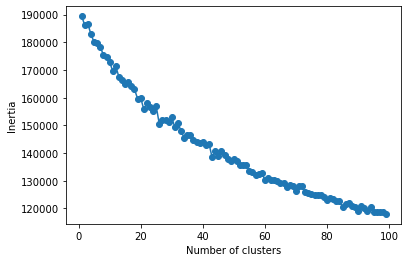

In [6]:
# first attempt at fitting K means to view change in Inertia
from sklearn.cluster import KMeans

# container to store inertia scores over iterations
distortions = []

# fit KMeans iteratively to begin to assess the appropriate number of clusters
for i in tqdm(range(1, 100)):
    km = KMeans(n_clusters=i)
    km.fit(amazonData.X)
    distortions.append(km.inertia_)
    
# vizualize change in inertia
plt.plot(range(1, 100), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

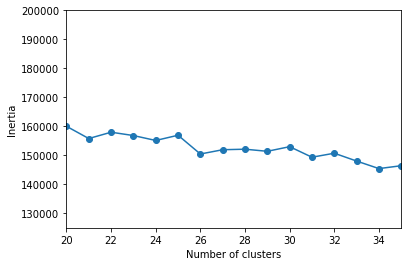

In [7]:
plt.plot(range(1, 100), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.axis((20,35,125000,200000))
plt.ylabel('Inertia')
plt.show()

### Choosing 26 for the value of the clusters as it seems like a area of potential "flattening" even though there is not a clear "elbow" in the plots

In [62]:
# fit KMeans with 26 clusters
from sklearn.cluster import KMeans
km_26 = KMeans(n_clusters=26, verbose = 1)
km_26.fit(amazonData.X)

Initialization complete
Iteration 0, inertia 199242.0
Iteration 1, inertia 163987.83313389777
Iteration 2, inertia 163293.90739974528
Iteration 3, inertia 162832.57929218473
Iteration 4, inertia 162677.04472657837
Iteration 5, inertia 162648.56640550375
Iteration 6, inertia 162623.18863399897
Iteration 7, inertia 162614.32284225847
Iteration 8, inertia 162610.62479448324
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 194096.0
Iteration 1, inertia 158236.96642706718
Iteration 2, inertia 157464.0529358582
Iteration 3, inertia 157399.76718622603
Iteration 4, inertia 157369.33905759017
Iteration 5, inertia 157346.15984011238
Iteration 6, inertia 157334.26323929636
Iteration 7, inertia 157330.73782703016
Iteration 8, inertia 157322.36588829785
Iteration 9, inertia 157319.22598101958
Iteration 10, inertia 157317.50116327504
Iteration 11, inertia 157315.43251422452
Iteration 12, inertia 157313.61470708757
Converged at iteration 12: strict convergenc

KMeans(n_clusters=26, verbose=1)

In [63]:
# create an instance of ViewClusteringResults to view results of final KMeans fit
viz = ViewClusteringResults(amazonData, km_26)

In [64]:
# view samples of product reviews, organized by KMeans cluster results
viz.view_cluster_samples(20)

y  \
136056                                                fyi   
9535                                                  fyi   
136083                         Good Inexpensive Cleanser.   
9780                            This is great quality tea   
364123                                     Red Clover Tea   
66544                                   Interesting taste   
135725                                   I Love Sage Tea!   
115605                        This stuff Smells so baaaad   
115517                                      Love this tea   
290339             useless - I feel no effects whatsoever   
23472                                        Rose Hip Tea   
17240                         Great herbal tea for cramps   
135618  Works, economical alternative to other 'diet' ...   
364151                                       nice product   
135685                               Birthing Miracle Tea   
9290                                      It warmed me up   
187285             

The clusters are making sense from the examples so far observed using the text data itself. However, after doing some reading on kmeans visualisation, I came across the `yellowbrick` package which is an wrapper for `scikit-learn` and `matplotlib` and allows us to create ML-specific visualisations using a high-level API. Source: [Yellowbrick](https://www.scikit-yb.org/en/latest/)

Using the `yellowbrick` package, I saw that an elbow existed at **3** but I decided that was too small to be considered as a clustering value (given that promising results I had with the earlier value of 26). Therefore, I ran the visualiser up to 100 clusters and was able to find a "better elbow" at **31**:

In [32]:
from yellowbrick.cluster import KElbowVisualizer

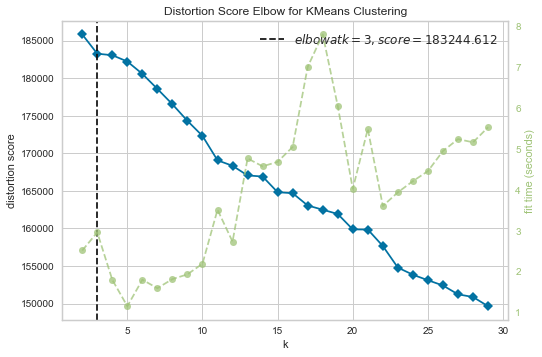

KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 k=None, model=None)

In [53]:
from yellowbrick.cluster.elbow import kelbow_visualizer
kelbow_visualizer(KMeans(random_state=4), amazonData.X, k=(2,30))

 123885.39463101655
Converged at iteration 16: strict convergence.
Initialization complete
Iteration 0, inertia 162280.0
Iteration 1, inertia 122559.2805508814
Iteration 2, inertia 122432.42373284191
Iteration 3, inertia 122273.22968254812
Iteration 4, inertia 121852.8712762577
Iteration 5, inertia 121774.39498806931
Iteration 6, inertia 121751.72383051037
Iteration 7, inertia 121732.88288704428
Iteration 8, inertia 121714.51792935134
Iteration 9, inertia 121700.52394464452
Iteration 10, inertia 121691.3381175597
Iteration 11, inertia 121680.68911463431
Iteration 12, inertia 121675.57217810013
Converged at iteration 12: strict convergence.
Initialization complete
Iteration 0, inertia 165804.0
Iteration 1, inertia 126316.02970909032
Iteration 2, inertia 125653.64171440995
Iteration 3, inertia 125433.7839227508
Iteration 4, inertia 125225.79038480327
Iteration 5, inertia 125050.87951969377
Iteration 6, inertia 125021.51698941804
Converged at iteration 6: strict convergence.
Initializatio

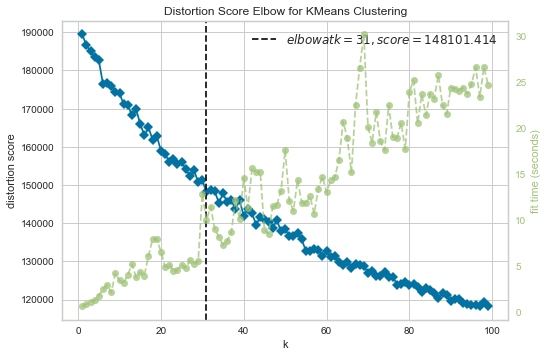

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [54]:
visualizer = KElbowVisualizer(km_26, k=(1,100))
visualizer.fit(amazonData.X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure


### Using a clustering value of 31 and investigating it's results:

In [65]:
# fit KMeans with 26 clusters
from sklearn.cluster import KMeans
km_31 = KMeans(n_clusters=31, verbose = 1)
km_31.fit(amazonData.X)

Initialization complete
Iteration 0, inertia 190092.0
Iteration 1, inertia 153726.90187847172
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 187851.0
Iteration 1, inertia 151275.67275540868
Iteration 2, inertia 151273.45095627
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 190510.0
Iteration 1, inertia 154070.34346752914
Iteration 2, inertia 153377.87026085655
Iteration 3, inertia 153147.68914430207
Iteration 4, inertia 153060.1854994349
Iteration 5, inertia 153044.37690516806
Iteration 6, inertia 152987.0378399752
Iteration 7, inertia 152859.7510490303
Iteration 8, inertia 152715.86581796908
Iteration 9, inertia 152597.1101893865
Iteration 10, inertia 152478.09972973124
Iteration 11, inertia 152267.37809931356
Converged at iteration 11: strict convergence.
Initialization complete
Iteration 0, inertia 191312.0
Iteration 1, inertia 155631.52517913777
Iteration 2, inertia 155549.87311980993
Iteration 

KMeans(n_clusters=31, verbose=1)

In [71]:
# create an instance of ViewClusteringResults to view results of final KMeans fit
viz = ViewClusteringResults(amazonData, km_31)

In [105]:
# view samples of product reviews, organized by KMeans cluster results
viz.view_cluster_samples(10)

--------------------------------------------------
cluster:  1
cluster size:  (2553, 4)
         ProductId  cluster                                    Summary  \
342327  B005VOOM4A        1               Strong Branding, Weak Flavor   
342837  B005VOONI0        1         BOB MARLEY WOULD LIKE THIS I THINK   
342668  B005VOONGM        1                Best Pod Coffee I've tasted   
341632  B005VOOLXM        1                              Love the pods   
341327  B005VOOKS8        1                          Surprisingly Good   
342918  B005VOONI0        1                        Road Trip Companion   
342653  B005VOONGM        1                                Bitter Brew   
341339  B005VOOKS8        1  Pretty good, if you have the right brewer   
342176  B005VOOM4A        1                         Just not that good   
342427  B005VOOM5E        1   Good smooth coffee for the right machine   

                                                     Text  
342327  I got my box of gourmet Marle

## Other checks around the data

In [26]:
test_data = pd.read_csv('../../data/Amazon.csv')

In [29]:
test_data.isnull().sum()

Unnamed: 0                     0
Id                             0
ProductId                      0
UserId                         0
ProfileName                   15
HelpfulnessNumerator           0
HelpfulnessDenominator         0
Score                          0
Time                           0
Summary                       23
Text                           0
helpScore                 216322
helpful                        0
dtype: int64

## Visualising the kMeans clustering

In [139]:
from yellowbrick.cluster import SilhouetteVisualizer

In [132]:
viz = ViewClusteringResults(amazonData, km_31)

In [138]:
viz.write_cluster_data().to_json('test.json')